In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os

os.environ['KERAS_BACKEND'] = 'plaidml.keras.backend'
import keras
from keras.models import Sequential
from keras.layers import Dense, LocallyConnected2D, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dropout, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras import regularizers
from keras import optimizers
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns

# Look at Data

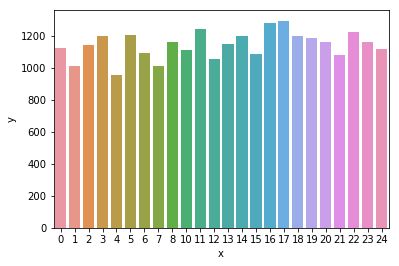

In [4]:
train = open('data/sign_mnist_train.csv')
train_df = pd.read_csv(train)
label_counts = pd.value_counts(train_df.label).to_frame()
label_counts['x'] = label_counts.index
label_counts = label_counts.rename(columns={'label': 'y'})
label_counts
sns.barplot(x='x', y='y', data=label_counts)

In [5]:
train = open('data/sign_mnist_train.csv')
test = open('data/sign_mnist_test.csv')

train_df = pd.read_csv(train)
test_df = pd.read_csv(test)

# labels represents letters. 
train_y_values = train_df.label.values
test_y_values = test_df.label.values

label_binarizer = LabelBinarizer()
train_y_values = label_binarizer.fit_transform(train_y_values)
test_y_values = label_binarizer.fit_transform(test_y_values)

train_df.drop('label', axis=1, inplace=True)
test_df.drop('label', axis=1, inplace=True)

In [6]:
train_images = np.array([row.values.reshape(28, 28) for i, row in train_df.iterrows()])
test_images = np.array([row.values.reshape(28, 28) for i, row in test_df.iterrows()])
#train_images = train_images / 255
#test_images = test_images / 255

In [7]:
x_train, x_valid, y_train, y_valid = train_test_split(train_images, train_y_values, 
                                                      test_size = 0.2,
                                                      random_state = 64209)

x_train = np.array(x_train)
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_valid = np.array(x_valid)
x_valid = x_valid.reshape(x_valid.shape[0], 28, 28, 1)

In [8]:
train_datagen = ImageDataGenerator(shear_range = 0.00,
                                   zoom_range = 0.10,
                                   rotation_range = 5,
                                   brightness_range = [0.05, 1.05],
                                   width_shift_range = [-2,-1, 0, +1, +2],
                                   height_shift_range = [ -1, 0, +1],
                                   fill_mode = 'reflect')
test_datagen = ImageDataGenerator()
 
train_datagen.fit(x_train)
#train_datagen.fit(x_valid)

# Lets look at some of the images

## Unaltered image

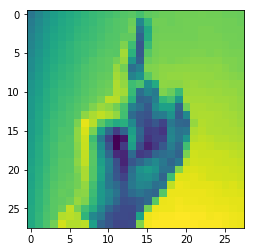

In [9]:
plt.imshow(train_images[0].reshape(28,28))

## Altered Image

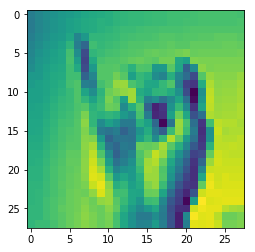

In [10]:
plt.imshow((train_datagen.flow(x_train)[0][0].reshape(28, 28)))

In [11]:
batch_size = 64
num_classes = 24
epochs = 64

In [24]:
def modelMaker(dropout_rate=.20, l_rate=.001):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), input_shape=(28, 28, 1), padding='same',
              kernel_regularizer=regularizers.l1_l2(l1=l_rate, l2=l_rate)))
    model.add(keras.layers.PReLU(alpha_initializer='zeros', 
                                 alpha_regularizer=None, alpha_constraint=None, 
                                 shared_axes=None))
    model.add(MaxPooling2D(pool_size = (3, 3), strides=2, padding='same'))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(64, kernel_size = (3, 3), padding='same', 
                     kernel_regularizer=regularizers.l1_l2(l1=l_rate, l2=l_rate)))
    model.add(keras.layers.PReLU(alpha_initializer='zeros', 
                                 alpha_regularizer=None, alpha_constraint=None, 
                                 shared_axes=None))
    model.add(MaxPooling2D(pool_size = (3, 3), strides=2, padding='same'))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(128, kernel_size = (4, 4), padding='same', 
                     kernel_regularizer=regularizers.l1_l2(l1=l_rate, l2=l_rate)))
    model.add(keras.layers.PReLU(alpha_initializer='zeros', 
                                 alpha_regularizer=None, alpha_constraint=None, 
                                 shared_axes=None))
    model.add(MaxPooling2D(pool_size = (3, 3), strides=2, padding='same'))
    model.add(Dropout(dropout_rate))
    
    model.add(Flatten())
    model.add(Dense(num_classes, activation = 'softmax', kernel_regularizer=regularizers.l1_l2(l1=l_rate, l2=l_rate)))

    model.compile(loss = keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
    return model

model = modelMaker()

In [25]:
plot_model(model, show_shapes=True, to_file='model.png')

In [26]:
# pure images
#history = model.fit(x_train, y_train, validation_data = (x_valid, y_valid), 
#                    epochs=epochs, batch_size=batch_size)
# altered images
history = model.fit_generator(train_datagen.flow(x_train, y_train, batch_size=batch_size), 
                              validation_data = (x_valid, y_valid), epochs=epochs)

Epoch 1/64


INFO:plaidml:Analyzing Ops: 430 of 447 operations complete


 97/344 [=======>......................] - ETA: 21s - loss: 11.5366 - acc: 0.0495

INFO:plaidml:Analyzing Ops: 138 of 447 operations complete


344/344 [==============================] - 25s 71ms/step - loss: 8.0384 - acc: 0.1799 - val_loss: 4.7758 - val_acc: 0.6174
Epoch 2/64
344/344 [==============================] - 7s 21ms/step - loss: 4.5261 - acc: 0.6275 - val_loss: 3.0968 - val_acc: 0.8940
Epoch 3/64
344/344 [==============================] - 7s 21ms/step - loss: 3.2829 - acc: 0.7666 - val_loss: 2.2602 - val_acc: 0.9499
Epoch 4/64
344/344 [==============================] - 7s 21ms/step - loss: 2.5003 - acc: 0.8194 - val_loss: 1.7514 - val_acc: 0.9481
Epoch 5/64
344/344 [==============================] - 7s 21ms/step - loss: 1.9868 - acc: 0.8495 - val_loss: 1.3538 - val_acc: 0.9678
Epoch 6/64
344/344 [==============================] - 7s 21ms/step - loss: 1.5969 - acc: 0.8755 - val_loss: 1.0685 - val_acc: 0.9876
Epoch 7/64
344/344 [==============================] - 7s 21ms/step - loss: 1.3611 - acc: 0.8885 - val_loss: 0.8995 - val_acc: 0.9909
Epoch 8/64
344/344 [==============================] - 7s 21ms/step - loss: 1.20

344/344 [==============================] - 7s 21ms/step - loss: 0.7158 - acc: 0.9553 - val_loss: 0.5562 - val_acc: 0.9996
Epoch 63/64
344/344 [==============================] - 7s 21ms/step - loss: 0.7312 - acc: 0.9544 - val_loss: 0.5583 - val_acc: 0.9949
Epoch 64/64
344/344 [==============================] - 7s 21ms/step - loss: 0.7198 - acc: 0.9539 - val_loss: 0.5528 - val_acc: 0.9993


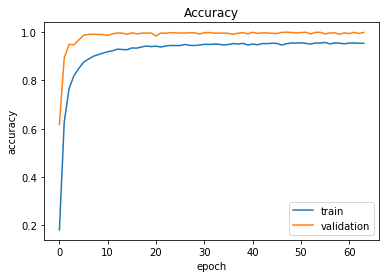

In [27]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title("Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','validation'])
plt.show()

In [28]:
test_images = np.array([i.flatten() for i in test_images])
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)
y_pred = model.predict(test_images)

accuracy_score(test_y_values, y_pred.round())



0.9919129949804797

In [ ]:
from ann_visualizer.visualize import ann_viz

ann_viz(model, title="My first neural network")